In [1]:
import os
import pandas as pd
import numpy as np
from graph_utils import (
    coverage_dayweek,
    coverage_mthyr,
    save_mpl_fig,
    its, 
    plotline, 
    plot_dual_indices
)
import warnings
warnings.filterwarnings('ignore')

FP = '../data/npr_cnn_textstat.csv.gz'
SAVEPATH = '../figs/'
os.makedirs(SAVEPATH, exist_ok=True) 

### Data Coverage

In [2]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      # Set date
      .assign(date=lambda df: df.date.str.replace('3007', '2007'))
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'))
      # Assign NPR or CNN
      .assign(npr=lambda df: np.where(df.id.str.contains('npr', case=False),1,0))
      .query('npr==1')
      .groupby(['date']).size().reset_index()      
      .rename(columns={0:'obs'})
      .assign(year=lambda df: [dt64.year for dt64 in df.date])
     )
df.head(3)

,date,obs,year
0,2005-05-01,6,2005
1,2005-05-02,23,2005
2,2005-05-03,23,2005


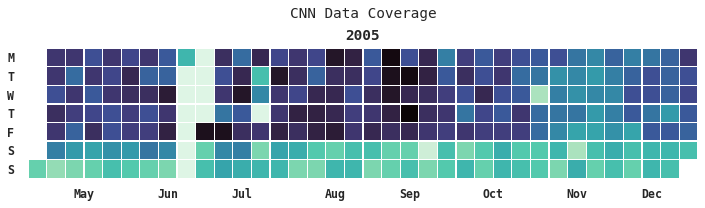

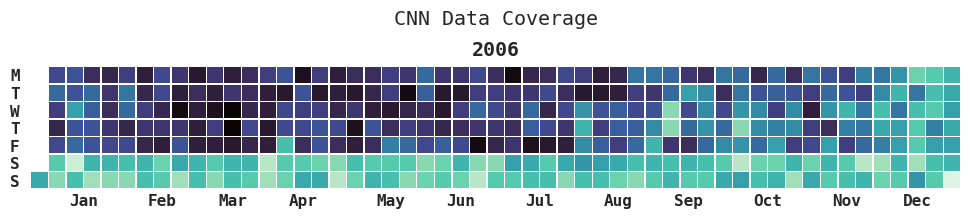

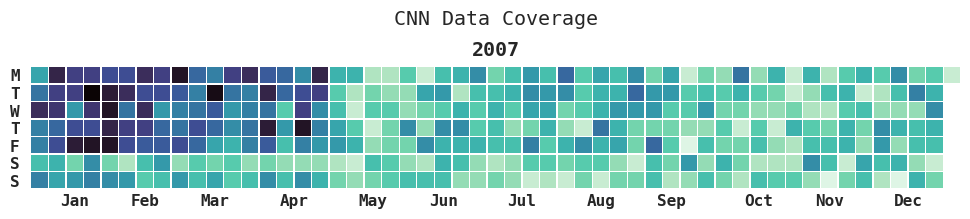

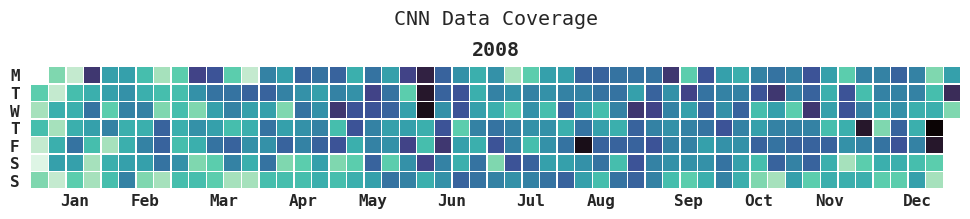

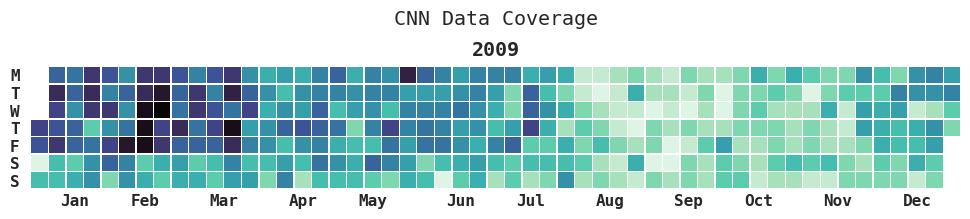

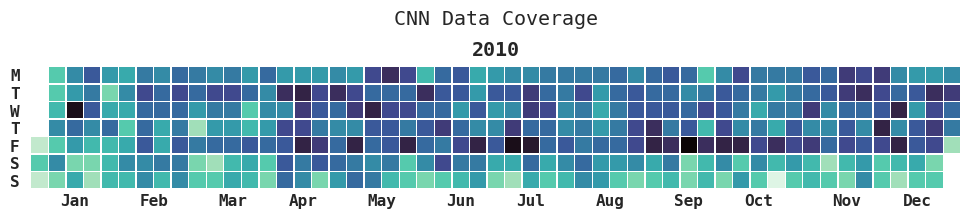

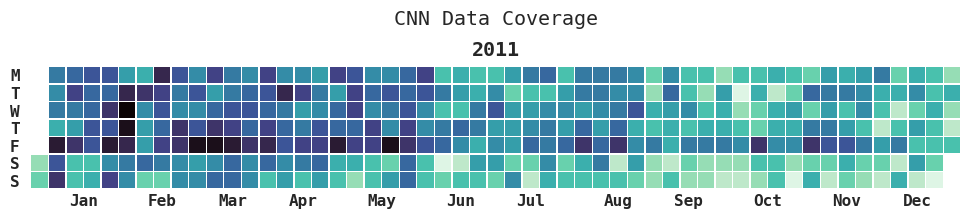

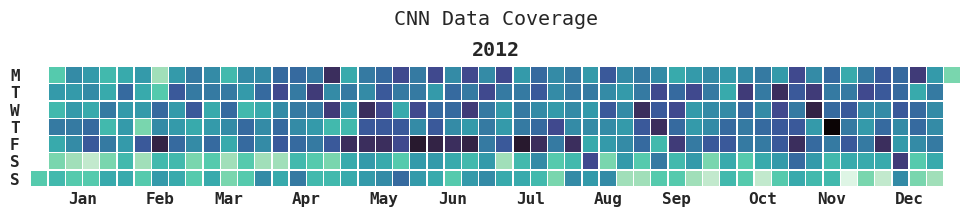

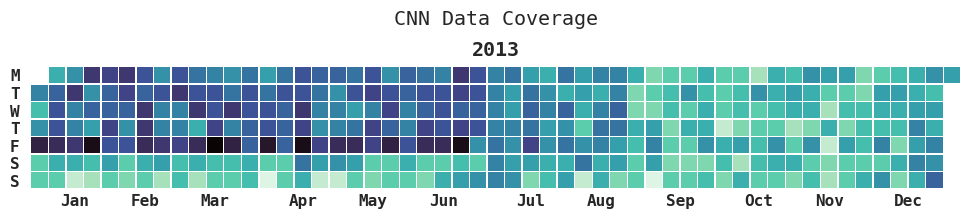

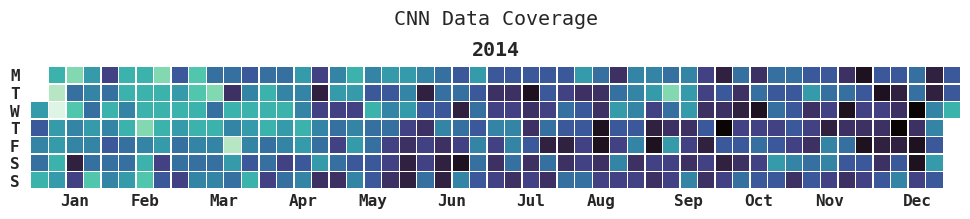

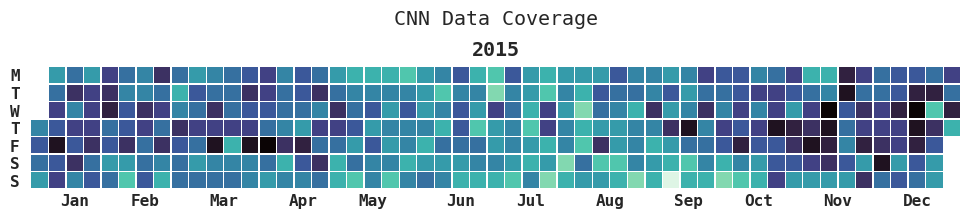

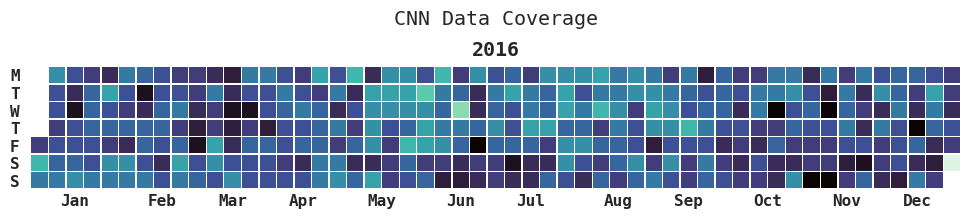

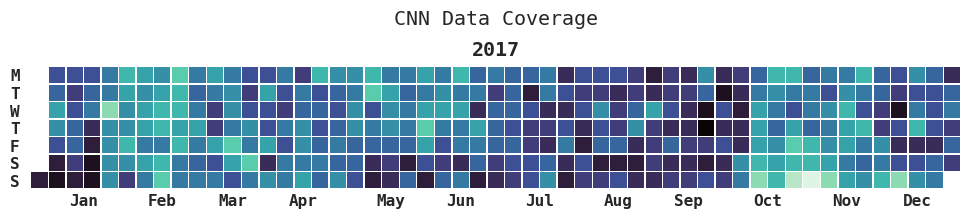

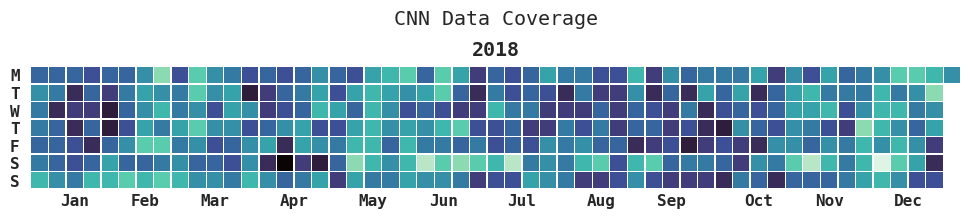

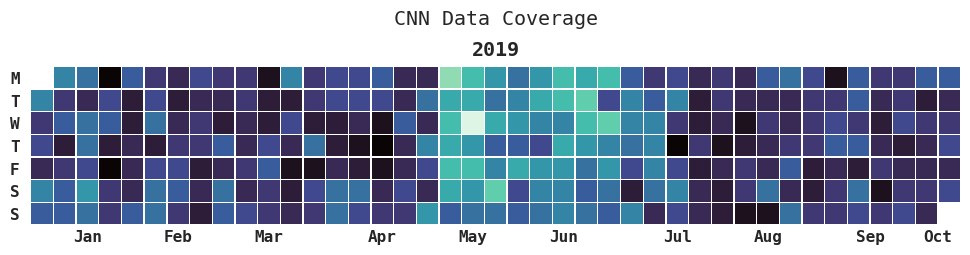

In [3]:
for year in df.year.unique():
    _df = df.query('year==@year')
    coverage_dayweek(_df.date, _df.obs, title='CNN Data Coverage')
    save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/npr_dowmonth_{year}'))

In [4]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      .assign(date=lambda df: df.date.str.replace('3007', '2007'))
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
             )      
      .set_index('date').groupby(pd.Grouper(freq='M')).size().reset_index()
      .rename(columns={0: 'count'})
      .assign(month=lambda df: [dt64.month_name()[:3] for dt64 in df.date],
              monthix=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date])
      .pivot(['month', 'monthix'], 'year', 'count')
      .sort_values('monthix').droplevel('monthix')
     )
df.head(3)

year,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,...,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
month,,,,,,,,,,,,,,,,,,,,,
Jan,1835.0,2017.0,1893.0,1345.0,861.0,776.0,1575.0,1311.0,1010.0,1197.0,...,1604.0,1902.0,2252.0,2251.0,2317.0,2966.0,2547.0,2543.0,2886.0,2370.0
Feb,1723.0,1877.0,1730.0,1166.0,957.0,740.0,1559.0,1094.0,1061.0,1217.0,...,1463.0,1820.0,2127.0,1949.0,2220.0,2797.0,2403.0,2403.0,2661.0,2478.0
Mar,2038.0,1089.0,1651.0,1376.0,852.0,865.0,1731.0,1140.0,1210.0,1372.0,...,1798.0,1956.0,2224.0,1893.0,2302.0,2764.0,2636.0,2800.0,3051.0,2391.0


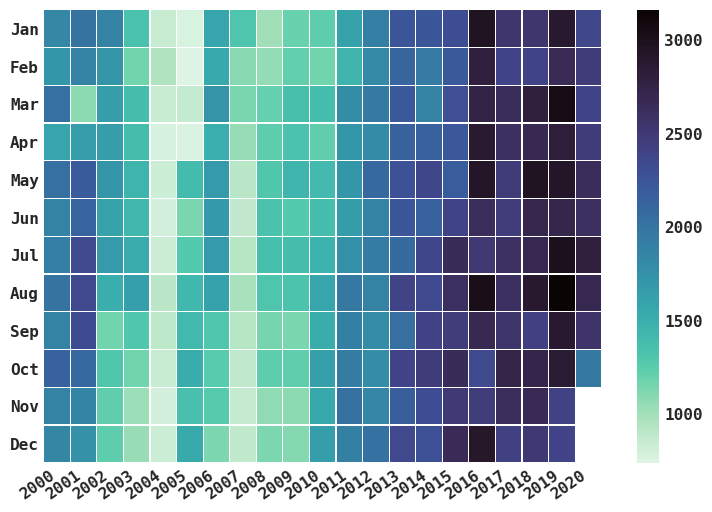

In [5]:
coverage_mthyr(df, xtickangle=35)
save_mpl_fig(os.path.join(SAVEPATH, f'data_coverage/npr_monthyear'))

### Readability & Lexical Richness

In [6]:
# (fold cell) Read & prep data
df = (pd.read_csv(FP)
      # Set date
      .assign(date=lambda df: df.date.str.replace('3007', '2007'))
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )      
      # Drop outliers by length
      .pipe(lambda df: 
            df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
      .query(f'terms>100')
      # Assign NPR or CNN
      .assign(npr=lambda df: np.where(df.id.str.contains('npr', case=False),1,0))
      .query('npr==1')
      .groupby(['mthyr']).mean().reset_index()
     )
df.head(3)

,mthyr,Unnamed: 0,flesch_reading_ease,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,year,npr
0,2005-05-01,33937.998179,64.464498,11.027271,11.519874,854.010929,343.612022,0.437371,91.212785,0.854964,5.0,2005.0,1
1,2005-06-01,34458.757746,63.799125,11.008790,11.641549,828.898592,335.540845,0.440545,91.575550,0.854819,6.0,2005.0,1
2,2005-07-01,34026.360958,64.985920,10.962341,11.380461,845.801105,341.548803,0.438009,93.226985,0.857028,7.0,2005.0,1


In [7]:
xrange=range(0,200,36)
xticklabels = range(2005,2021,3)

<AxesSubplot:title={'left':'Word Count per Article'}, xlabel='Publication year'>

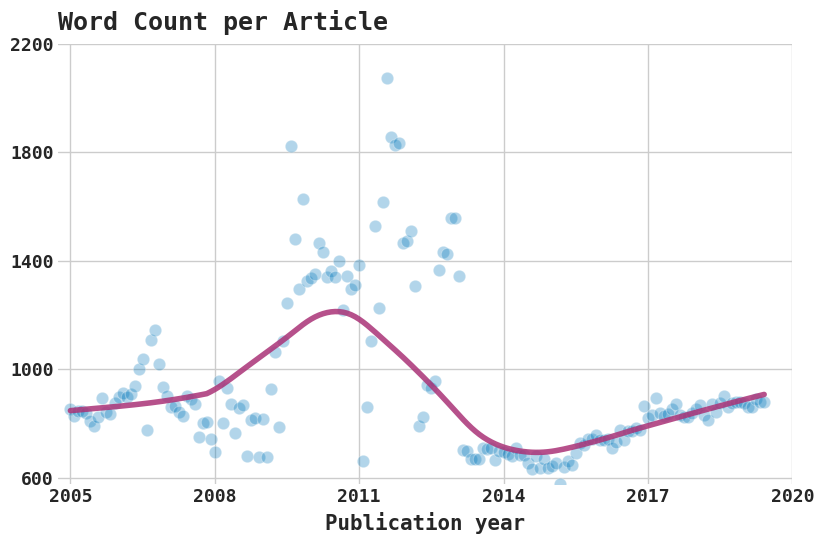

In [8]:
plotline(x=df.index, y=df.terms, 
         xrange=xrange, xticklabels=xticklabels,
         yrange=range(600,2300,400), 
         title='Word Count per Article', 
         savepath=os.path.join(SAVEPATH, 'npr_wordcount')
        )    

<AxesSubplot:title={'left':'Unique Words per Article'}, xlabel='Publication year'>

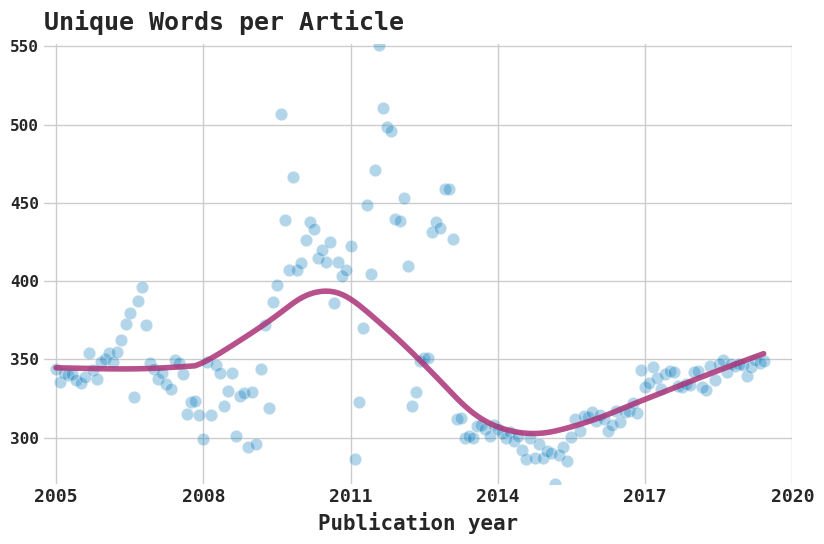

In [9]:
plotline(x=df.index, y=df.uniqueterms,
         xrange=xrange, xticklabels=xticklabels,
         title='Unique Words per Article', 
         savepath=os.path.join(SAVEPATH, 'npr_uniquewords')
        ) 

<AxesSubplot:title={'left':'Readability (Flesch Reading Ease)'}, xlabel='Publication year'>

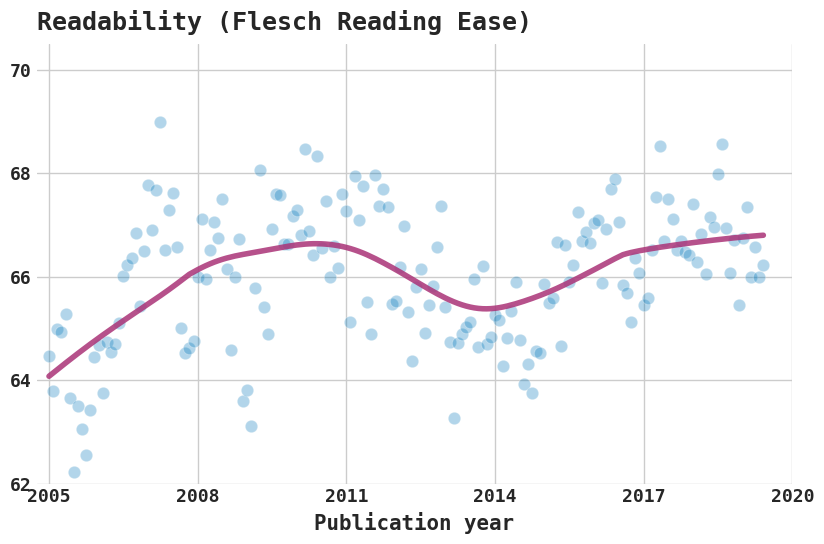

In [10]:
plotline(x=df.index, y=df.flesch_reading_ease,
         xrange=xrange, xticklabels=xticklabels,
         yrange=range(62, 72, 2), 
         title='Readability (Flesch Reading Ease)',
         savepath=os.path.join(SAVEPATH, 'npr_readability_flesch_ease'))    

<AxesSubplot:title={'left':'Lexical Richness (MTLD)'}, xlabel='Publication year'>

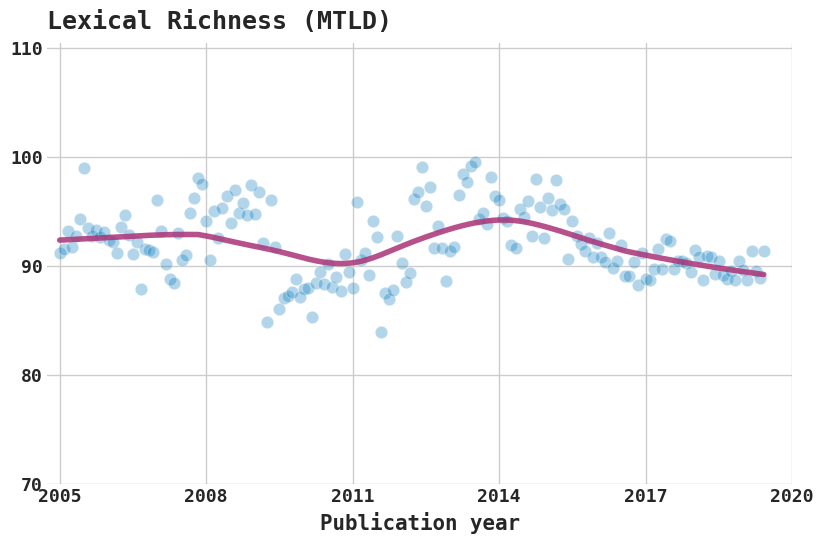

In [11]:
plotline(x=df.index, y=df.mtld, yrange=range(70,120,10), 
         xrange=xrange, xticklabels=xticklabels,         
         title='Lexical Richness (MTLD)', 
         savepath=os.path.join(SAVEPATH, 'npr_lexicalrichness_mtld'))    

In [12]:
# (fold cell) Prep indices
idf = (pd.read_csv(FP)
      # Set date
      .assign(date=lambda df: df.date.str.replace('3007', '2007'))
      .assign(date=lambda df: pd.to_datetime(df.date, errors='coerce'),
              month=lambda df: [dt64.month for dt64 in df.date],
              year=lambda df: [dt64.year for dt64 in df.date],
              mthyr=lambda df: pd.to_datetime(df[['year', 'month']].assign(day=1)),
             )      
       # Drop outliers by length
      .pipe(lambda df: 
            df.query(f'terms>{df.terms.quantile(q=0.01)} & terms<{df.terms.quantile(q=0.99)}'))
       .query(f'terms>100')
      # Assign NPR or CNN
      .assign(npr=lambda df: np.where(df.id.str.contains('npr', case=False),1,0))
      .query('npr==1')
      .groupby(['year']).mean().reset_index()
      .assign(
          iflesch_reading_ease=lambda df: df.apply(its, base=df.loc[0,'flesch_reading_ease'], x='flesch_reading_ease', axis=1),
          ismog=lambda df: df.apply(its, base=df.loc[0,'smog'], x='smog', axis=1),
          imtld=lambda df: df.apply(its, base=df.loc[0,'mtld'], x='mtld', axis=1),
          ittr=lambda df: df.apply(its, base=df.loc[0,'ttr'], x='ttr', axis=1),
          iword=lambda df: df.apply(its, base=df.loc[0,'terms'], x='terms', axis=1),
          iuniqueterms=lambda df: df.apply(its, base=df.loc[0,'uniqueterms'], x='uniqueterms', axis=1),
             )
     )
idf.head(3)

,year,Unnamed: 0,flesch_reading_ease,fog,smog,terms,uniqueterms,ttr,mtld,hdd,month,npr,iflesch_reading_ease,ismog,imtld,ittr,iword,iuniqueterms
0,2005.0,34386.843410,64.241450,11.043423,11.564032,831.453580,339.424235,0.439545,93.199639,0.856365,8.408045,1,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,2006.0,32284.186339,64.316209,11.009851,11.512243,900.041810,352.461459,0.433809,92.650323,0.856054,6.065898,1,0.116372,-0.447846,-0.589397,-1.30504,8.249195,3.840982
2,2007.0,21009.457878,66.837951,10.574863,10.975922,968.526911,359.806162,0.428191,90.767000,0.855819,5.215679,1,4.041783,-5.085682,-2.610137,-2.58330,16.485987,6.004853


<AxesSubplot:xlabel='Publication year', ylabel='Percentage change since 2005'>

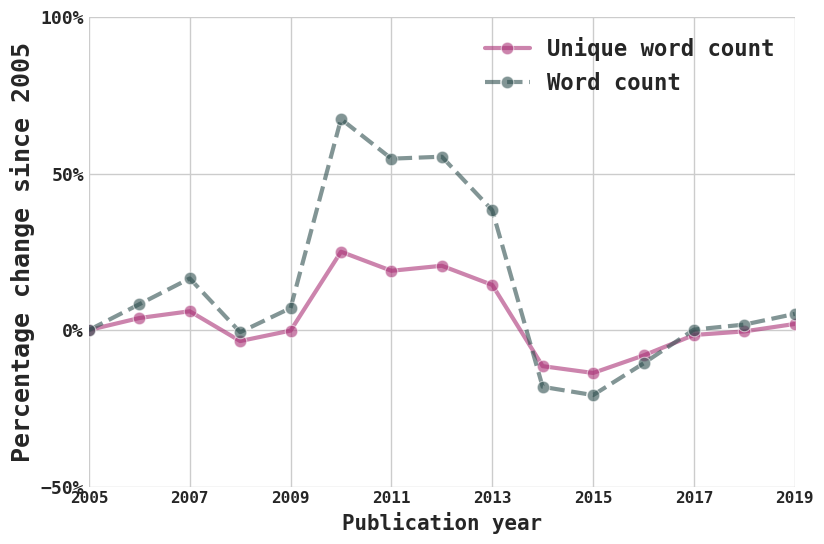

In [13]:
plot_dual_indices(x=idf.year, y1=idf.iuniqueterms, y2=idf.iword, 
                  label1='Unique word count', label2='Word count',
                  yrange=range(-50,150,50),
                  xrange=range(2005, 2020, 2),
                  ylabel='Percentage change since 2005',
                  savepath=os.path.join(SAVEPATH, 'npr_words_uniquewords')
                 )    

<AxesSubplot:title={'left':'Readability'}, xlabel='Publication year', ylabel='Percentage change since 2005'>

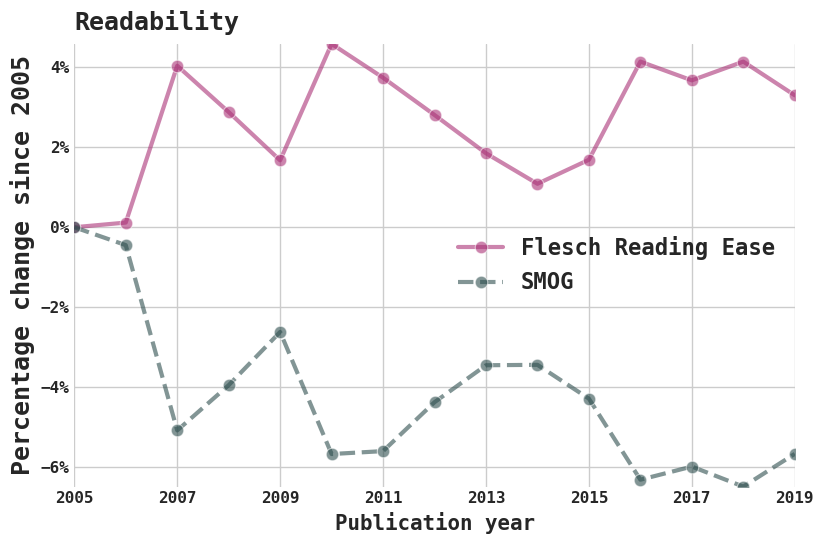

In [14]:
plot_dual_indices(x=idf.year, y1=idf.iflesch_reading_ease, y2=idf.ismog, 
                  label1='Flesch Reading Ease', label2='SMOG', title='Readability',
                  xrange=range(2005, 2020, 2),
                  ylabel='Percentage change since 2005',
                  savepath=os.path.join(SAVEPATH, 'npr_readability_index')
                 )    


<AxesSubplot:title={'left':'Lexical Richness'}, xlabel='Publication year', ylabel='Percentage change since 2005'>

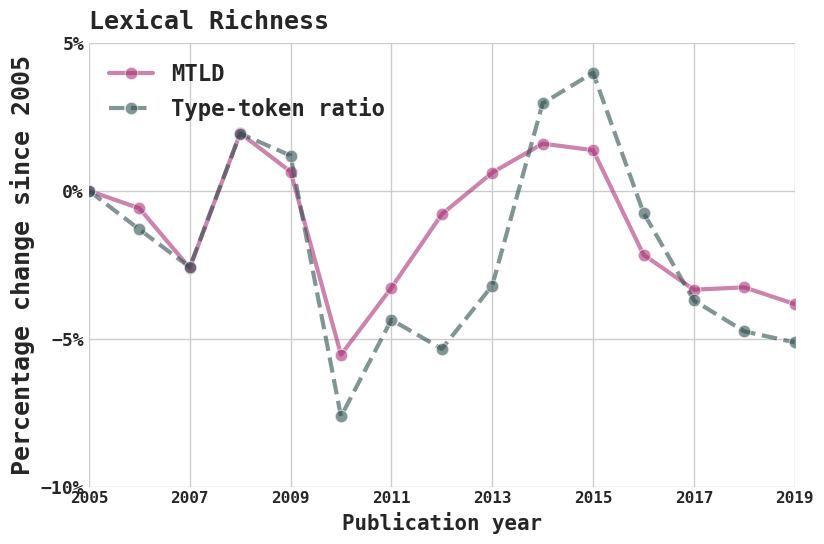

In [15]:
plot_dual_indices(x=idf.year, y1=idf.imtld, y2=idf.ittr, 
                  xrange=range(2005, 2020, 2),
                  yrange=range(-10,10,5), 
                  label1='MTLD', label2='Type-token ratio', title='Lexical Richness', 
                  ylabel='Percentage change since 2005',
                  savepath=os.path.join(SAVEPATH, 'npr_lexicalrichness_index')
                 )    
